In [3]:
# !pip install lifelines

In [8]:
import os
import joblib
import numpy as np
import pandas as pd
import polars as pl

import dproc, sgutil, sgpp, sgml

import pandas.api.types
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

import lifelines
from lifelines.utils import concordance_index

import sys

print(sys.version)
for i in [np, pd, pl, mpl, sns, lifelines]:
    try:
        print(i.__name__, i.__version__)
    except:
        print(i.__name__)

3.12.6 (main, Sep 30 2024, 02:19:13) [GCC 9.4.0]
numpy 1.26.4
pandas 2.2.3
polars 1.12.0
matplotlib 3.8.4
seaborn 0.13.2
lifelines 0.30.0


In [69]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

In [5]:
data_path = 'data'
img_path = 'img'
result_path = 'result'
model_path = 'model'
for i in [data_path, img_path, result_path, model_path]:
    if not os.path.exists(i):
        os.mkdir(i)

if not os.path.exists(os.path.join(data_path, 'train.csv')):
    !kaggle competitions download -c equity-post-HCT-survival-predictions
    !unzip equity-post-HCT-survival-predictions.zip -d data
    !rm equity-post-HCT-survival-predictions.zip

sc = sgutil.SGCache('img', 'result')

In [41]:
X_4 = [
    'psych_disturb', 'diabetes', 'arrhythmia', 'renal_issue', 'pulm_severe', 'obesity', 'hepatic_severe', 
    'prior_tumor', 'peptic_ulcer','rheum_issue', 'hepatic_mild', 'cardiac','pulm_moderate'
]

expr_X_2 = {
    v: pl.col(v).cast(pl.String).replace(d).cast(pl.Int8).fill_null(0)
    for v, d in [
        ('graft_type', {'Peripheral blood': 0, 'Bone marrow': 1}),
        ('prod_type', {'PB': 0, 'BM': 1}),
        ('vent_hist', {'No': -1, 'Yes': 1}),
        ('rituximab', {'No': -1, 'Yes': 1}),
        ('mrd_hct', {'Negative': -1, 'Positive': 1}),
        ('in_vivo_tcd', {'No': -1, 'Yes': 1}),
        ('melphalan_dose', {'N/A, Mel not given': -1, 'MEL': 1})
    ]
}
expr_X_4_na = {
    i + '_na': pl.col(i).is_null() for i in X_4
}
expr_X_4 = {
    i : pl.col(i).cast(pl.String).replace({'No': -1, 'Yes': 1, 'Not done': 0}).cast(pl.Int8).fill_null(0) for i in X_4
}

p1 = make_pipeline(
    sgpp.PolarsProcessor(),
    sgpp.ExprProcessor({**expr_X_2, **expr_X_4_na, **expr_X_4}),
    sgpp.PandasCoverter(index_col = 'ID')
)
df_train = p1.fit_transform(['data/train.csv'])

In [42]:
df_train

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,renal_issue_na,pulm_severe_na,obesity_na,hepatic_severe_na,prior_tumor_na,peptic_ulcer_na,rheum_issue_na,hepatic_mild_na,cardiac_na,pulm_moderate_na
ID,,,,,,,,,,,,,,,,,,,,,
0,N/A - non-malignant indication,-1,NaN,-1,NaN,NaN,No TBI,-1,6.0,1,...,False,False,False,False,False,False,False,False,False,False
1,Intermediate,-1,Intermediate,-1,2.0,8.0,"TBI +- Other, >cGy",-1,6.0,0,...,False,False,False,False,False,False,False,False,False,False
2,N/A - non-malignant indication,-1,NaN,-1,2.0,8.0,No TBI,-1,6.0,1,...,False,False,False,False,False,False,False,False,False,False
3,High,-1,Intermediate,-1,2.0,8.0,No TBI,-1,6.0,1,...,False,False,False,False,False,False,False,False,False,False
4,High,-1,NaN,-1,2.0,8.0,No TBI,-1,6.0,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,Intermediate - TED AML case <missing cytogenetics,0,Favorable,-1,2.0,8.0,No TBI,-1,6.0,0,...,False,True,False,False,False,False,True,True,True,False
28796,High,-1,Poor,1,1.0,4.0,No TBI,-1,5.0,0,...,False,False,False,False,False,False,False,False,False,False
28797,TBD cytogenetics,0,Poor,0,2.0,8.0,No TBI,0,6.0,0,...,True,True,False,False,False,True,True,True,True,False


In [43]:
X_bool = ['graft_type', 'prod_type']
X_tri = [
    'arrhythmia', 'cardiac', 'diabetes', 'hepatic_mild', 'hepatic_severe',
    'in_vivo_tcd', 'melphalan_dose', 'mrd_hct', 'obesity', 'peptic_ulcer',
    'prior_tumor', 'psych_disturb', 'pulm_moderate', 'pulm_severe', 'renal_issue',
    'rheum_issue', 'rituximab', 'vent_hist'
]
X_nom = [
    'cmv_status', 'conditioning_intensity', 'cyto_score', 'cyto_score_detail', 'donor_related',
    'dri_score', 'ethnicity', 'gvhd_proph', 'prim_disease_hct', 'race_group', 'sex_match',
    'tbi_status', 'tce_div_match', 'tce_imm_match', 'tce_match'
]
X_na = [
    'arrhythmia_na', 'cardiac_na', 'diabetes_na', 'hepatic_mild_na', 'hepatic_severe_na',
    'obesity_na', 'peptic_ulcer_na', 'prior_tumor_na', 'psych_disturb_na', 'pulm_moderate_na',
    'pulm_severe_na', 'renal_issue_na', 'rheum_issue_na'
]
X_cont = ['age_at_hct', 'donor_age']
X_int = [
    'comorbidity_score', 'hla_high_res_10', 'hla_high_res_6', 'hla_high_res_8', 'hla_low_res_10',
    'hla_low_res_6', 'hla_low_res_8', 'hla_match_a_high', 'hla_match_a_low', 'hla_match_b_high',
    'hla_match_b_low', 'hla_match_drb1_low', 'hla_match_c_high', 'hla_match_c_low', 'hla_match_dqb1_high', 'hla_match_dqb1_low',
    'hla_match_drb1_high', 'hla_nmdp_6', 'karnofsky_score', 'year_hct'
]
X_all = X_bool + X_tri + X_nom + X_na + X_cont + X_int

# Target

In [44]:
pd.concat([
    df_train['efs'].value_counts().rename('count'),
    df_train['efs'].value_counts(normalize = True).rename('ratio')
], axis=1)

,count,ratio
efs,,
1.0,15532,0.539306
0.0,13268,0.460694


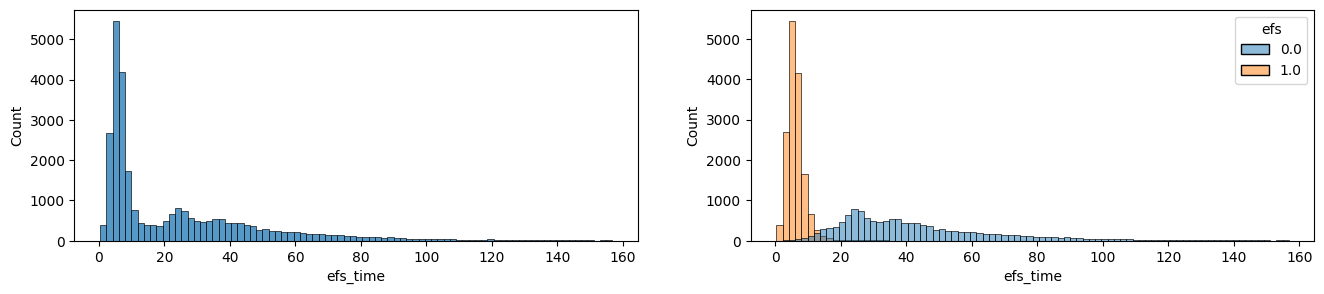

In [45]:
fig, axes = plt.subplots(1, 2, figsize = (16, 3))
sns.histplot(df_train, x = 'efs_time', ax = axes[0])
sns.histplot(df_train, x = 'efs_time', hue='efs', ax = axes[1])
plt.show()

In [46]:
df_train.pivot_table(index = 'efs', columns = 'race_group', aggfunc = 'size', observed = True)

race_group,More than one race,Asian,White,American Indian or Alaska Native,Native Hawaiian or other Pacific Islander,Black or African-American
efs,,,,,,
0.0,2588,2167,1809,2345,2243,2116
1.0,2257,2665,3022,2445,2464,2679


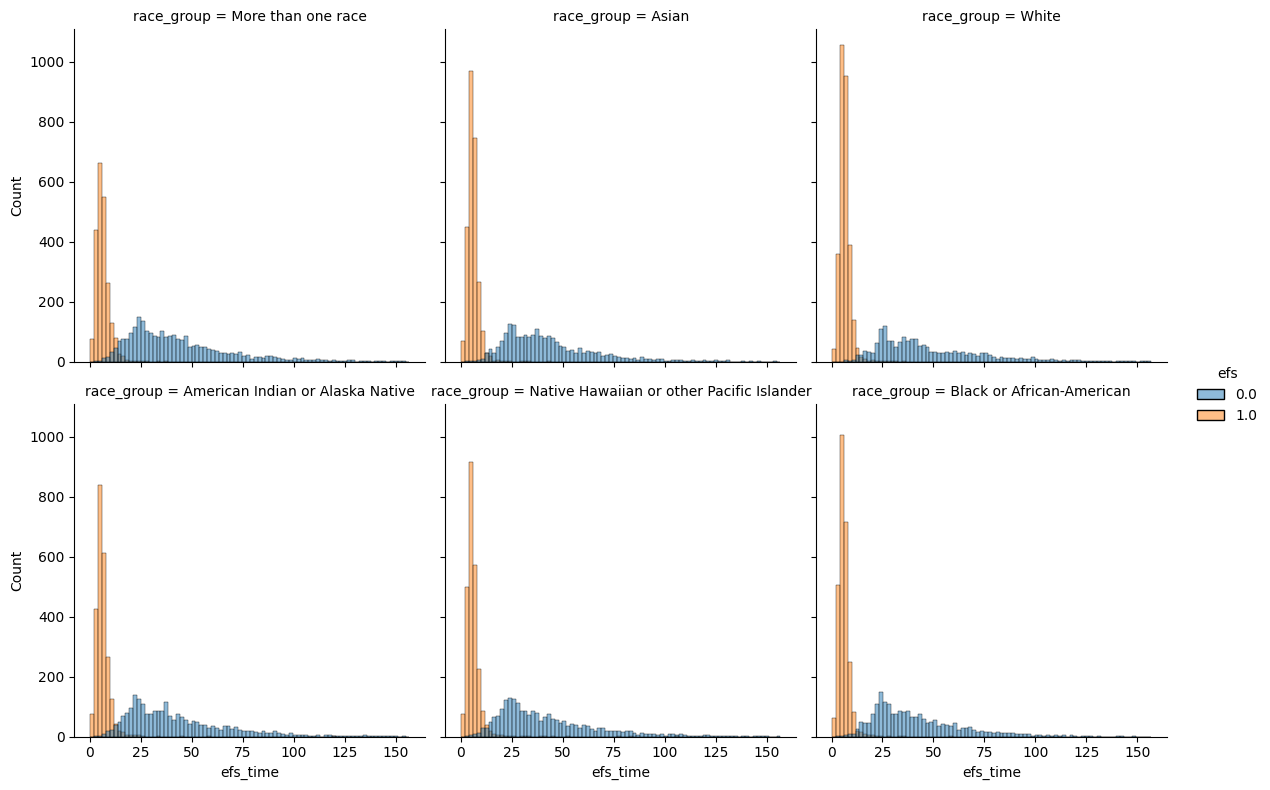

In [47]:
sns.displot(df_train, x = 'efs_time', hue = 'efs', col = 'race_group', col_wrap = 3, height = 4)
plt.show()

In [48]:
def concordance_index_pd(event_times, scores, event_observed):
    """
    Calculate the Concordance Index (C-Index) using pandas.

    Parameters:
    ----------
    event_times : pd.Series or array-like
        A sequence of times indicating when the event of interest occurred or when censoring happened.

    scores : pd.Series or array-like
        The predicted risk scores for each observation. Higher scores indicate higher risk.

    event_observed : pd.Series or array-like
        A binary sequence where 1 indicates the event was observed (not censored) and 0 indicates censoring.

    Returns:
    -------
    c_index : float
        The Concordance Index, which measures how well the predicted scores align with the observed event times. 
        Values closer to 1 indicate better predictive accuracy, while values closer to 0.5 indicate random predictions.

    Function Logic:
    ---------------
    1. Combine the input `event_times`, `scores`, and `event_observed` into a pandas DataFrame:
        - If any input is not a pandas Series, it is converted into one.
        - Columns are named 'times', 'scores', and 'event' respectively.

    2. Sort the DataFrame by `event_times` in descending order, ensuring that later events appear first.

    3. Create a new column, `seq`, which assigns ranks to the event times in descending order. The rank represents the 
       number of preceding observations in the sorted DataFrame.

    4. Filter the DataFrame to only include rows where `event_observed` is 1.0 (i.e., the event was observed).

    5. For each remaining row:
        - Compare the predicted `scores` with all preceding scores (based on the `seq` value).
        - Count how many preceding scores are less than the current score (`l_cnt`).
        - Count ties and assign them a weight of 0.5.

    6. Compute the Concordance Index as:
        - The sum of `l_cnt` divided by the total possible comparisons (`seq.sum()`).

    Notes:
    ------
    - This implementation assumes higher `scores` indicate higher risk.
    - Ties in `scores` are handled by assigning them a partial weight (0.5).
    - The function uses pandas operations for processing, making it suitable for datasets already structured as pandas DataFrames.
    """
    return pd.concat([
        event_times.rename('times') if type(event_times) is pd.Series else pd.Series(event_times, name = 'times'), 
        scores.rename('scores') if type(scores) is pd.Series else pd.Series(scores, name = 'scores'), 
        event_observed.rename('event') if type(event_observed) is pd.Series else pd.Series(event_observed, name = 'event')
    ], axis=1).sort_values('times', ascending = False).assign(
        seq = lambda x: x['times'].rank(method = 'min', ascending = False) - 1
    ).pipe(
        lambda y: y.loc[y['event'] == 1.0].assign(
            l_cnt = lambda x: x[['scores', 'seq']].apply(
                lambda x: y['scores'].iloc[:int(x['seq'])].pipe(
                    lambda z: ((x['scores'] < z).sum() + (x['scores'] == z).sum() * 0.5)
                ), axis=1
            )
        )
    ).pipe(
        lambda x: x['l_cnt'].sum() / x['seq'].sum()
    )

# EDA

## Categorical Variables

In [49]:
from scipy.stats import chi2_contingency, kruskal, spearmanr
from scipy.spatial.distance import pdist,squareform

In [50]:
sc.cache_result(
    'chi2_efs',
    lambda : pd.concat([
        pd.Series(
            chi2_contingency(
                df_train.pivot_table(index = i, columns = 'efs', aggfunc='size', observed=True).fillna(0)
            )[:2], index = ['stat', 'pvalue'], name = i
        ) for i in X_bool + X_tri + X_na + X_nom
    ], axis=1), rerun = 0
).T.sort_values(['pvalue', 'stat'], ascending = [True, False]).query('pvalue < 0.05')

,stat,pvalue
prim_disease_hct,2161.853494,0.000000e+00
dri_score,1531.593990,0.000000e+00
graft_type,1444.903038,0.000000e+00
prod_type,1437.863600,0.000000e+00
gvhd_proph,875.655168,4.441921e-176
in_vivo_tcd,775.462801,4.077483e-169
conditioning_intensity,356.162774,8.244813e-75
cmv_status,293.166975,2.996207e-63
cardiac,270.772639,1.593927e-59
race_group,280.834664,1.317205e-58


In [51]:
sc.cache_result(
    'kruskal_efs_time',
    lambda : pd.concat([
        pd.Series(
            kruskal(*df_train.groupby(i, observed = True)['efs_time'].agg(list)),
            index = ['stat', 'pvalue'], name = i
        ) for i in X_bool + X_tri + X_na + X_nom
    ], axis=1), rerun = 0
).T.sort_values('pvalue').query('pvalue < 0.05')

,stat,pvalue
prim_disease_hct,1371.490760,2.057605e-281
dri_score,1141.420147,6.198183e-239
prod_type,872.553348,9.088574e-192
graft_type,857.625547,1.598693e-188
cyto_score_detail,536.046526,1.068478e-114
in_vivo_tcd,448.848569,3.417997e-98
gvhd_proph,446.097947,7.607048e-85
cardiac,332.275751,7.034568e-73
pulm_severe,332.092845,7.708234e-73
cmv_status,318.171178,1.160475e-68


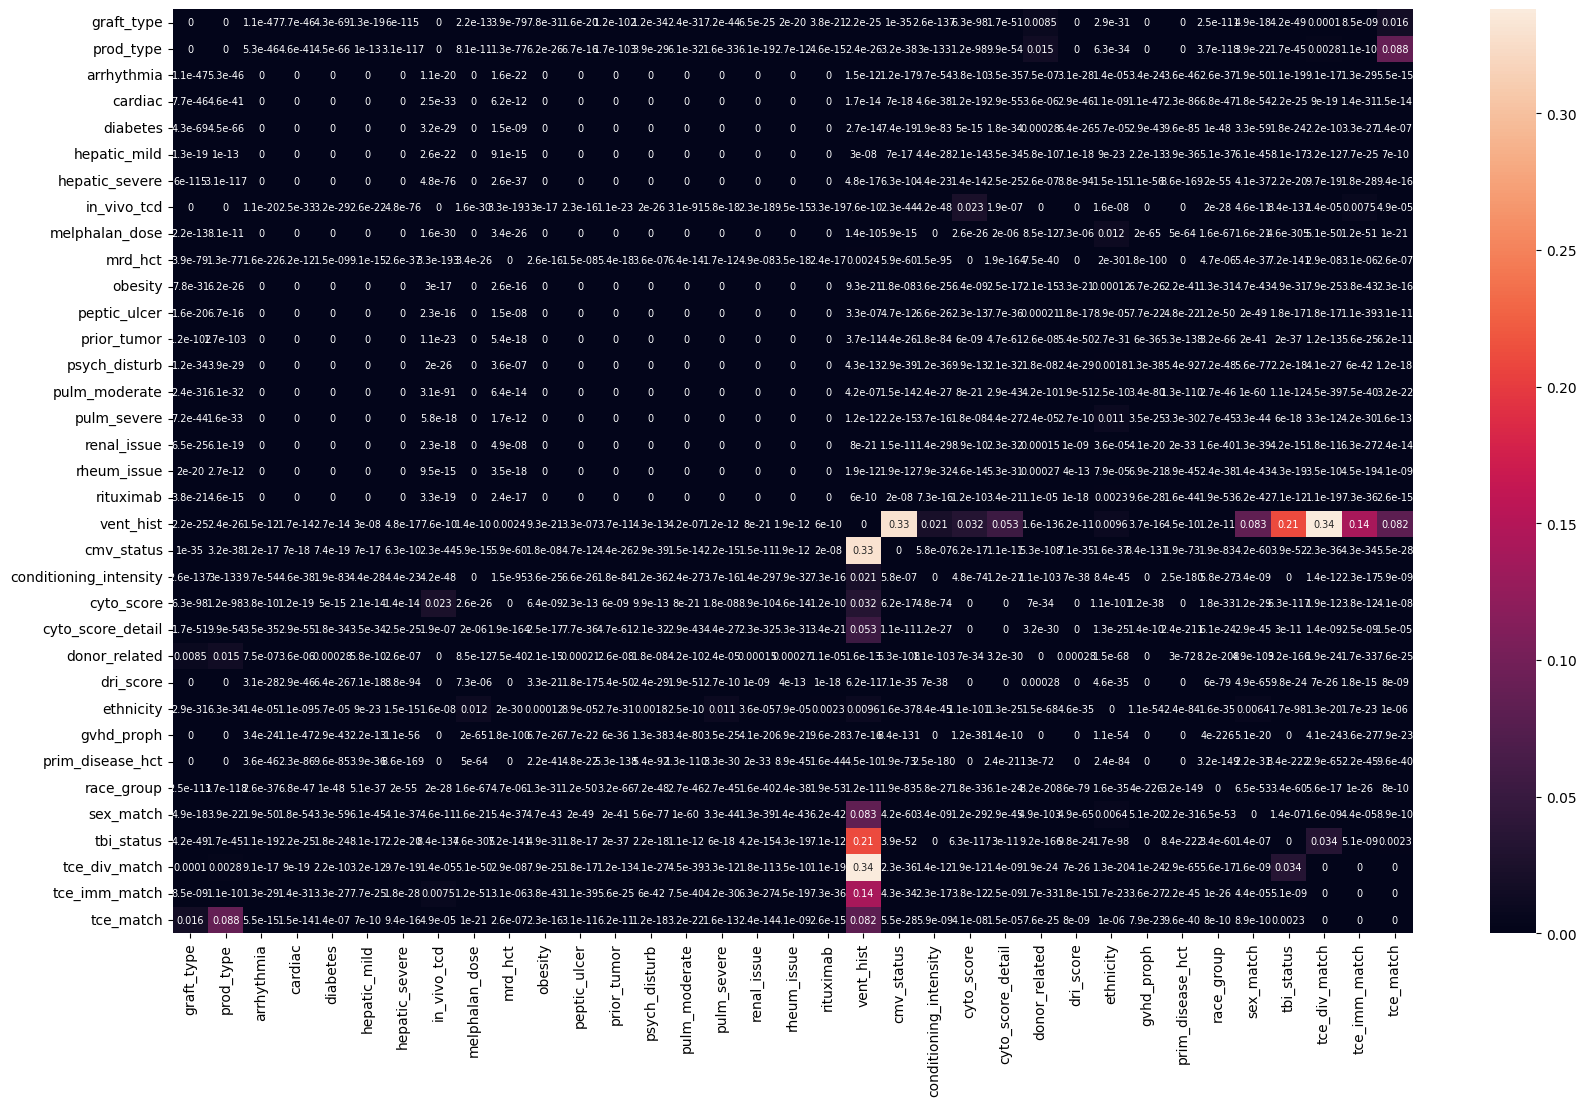

In [52]:
plt.figure(figsize = (20, 12))
chi2_result = sc.cache_result(
    'chi2_vars',
    lambda : pdist(df_train[X_bool + X_tri + X_nom].T, lambda u, v: chi2_contingency(pd.crosstab(index=u, columns=v))[1]),
    rerun=0
)
sns.heatmap(
    pd.DataFrame(
        squareform(chi2_result), index = X_bool + X_tri + X_nom, columns = X_bool + X_tri + X_nom
    ), annot=True, annot_kws = {'size': 7}
)
plt.show()

## Continuous Variables

In [53]:
sc.cache_result(
    'kruskal_efs',
    lambda : pd.concat([
        pd.Series(
            kruskal(*df_train.groupby('efs', observed = True)[i].agg(lambda x: list(x.dropna()))),
            index = ['stat', 'pvalue'], name = i
        ) for i in X_int + X_cont
    ], axis=1), rerun = 0
).T.sort_values('pvalue')

,stat,pvalue
age_at_hct,1350.047498,1.504372e-295
comorbidity_score,474.884814,2.772101e-105
year_hct,356.672993,1.492930e-79
karnofsky_score,253.615358,4.229424e-57
hla_match_drb1_high,139.814217,2.923077e-32
hla_match_drb1_low,119.119768,9.859315e-28
hla_low_res_6,65.026820,7.388558e-16
hla_high_res_10,55.077556,1.158665e-13
hla_high_res_6,52.572324,4.146921e-13
hla_low_res_10,52.425553,4.468713e-13


In [54]:
sc.cache_result(
    'spearman_efs_time',
    lambda : pd.concat([
        pd.Series(
            df_train[[i, 'efs_time']].dropna().pipe(lambda x: spearmanr(x[i], x['efs_time'])),
            index = ['r', 'pvalue'], name = i
        ) for i in X_int + X_cont
    ], axis=1), rerun = 1
).T.sort_values('pvalue')

,r,pvalue
age_at_hct,-0.173477,2.238721e-193
comorbidity_score,-0.169469,1.737400e-181
karnofsky_score,0.131331,1.117060e-107
year_hct,-0.127900,2.651906e-105
hla_match_a_high,0.043460,1.008486e-11
hla_match_a_low,0.041624,1.314871e-11
hla_match_c_low,0.034575,2.455235e-08
donor_age,-0.032817,6.934973e-08
hla_match_b_high,0.033254,1.706890e-07
hla_nmdp_6,0.029183,4.688798e-06


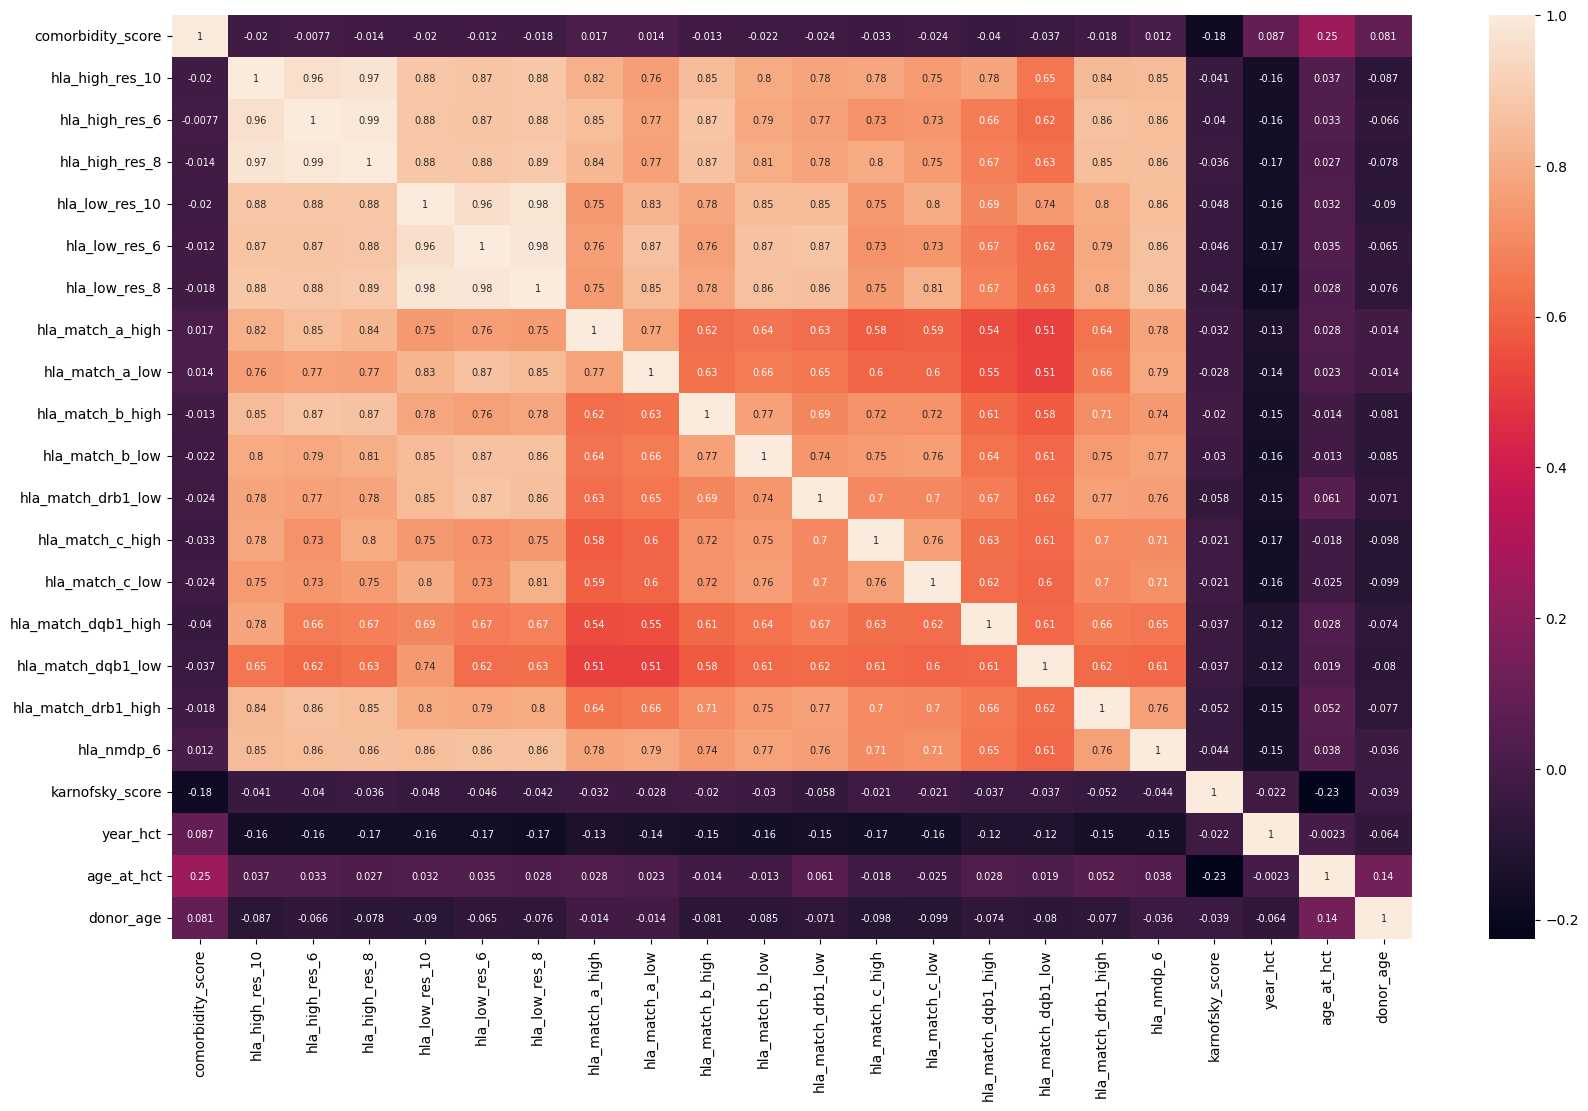

In [55]:
plt.figure(figsize = (20, 12))
corr_result = sc.cache_result(
    'spearman_vars',
    lambda : df_train[X_int + X_cont].corr('spearman'),
    rerun=1
)
sns.heatmap(
    pd.DataFrame(
        corr_result, index = X_int + X_cont, columns = X_int + X_cont
    ), annot=True, annot_kws = {'size': 7}
)
plt.show()

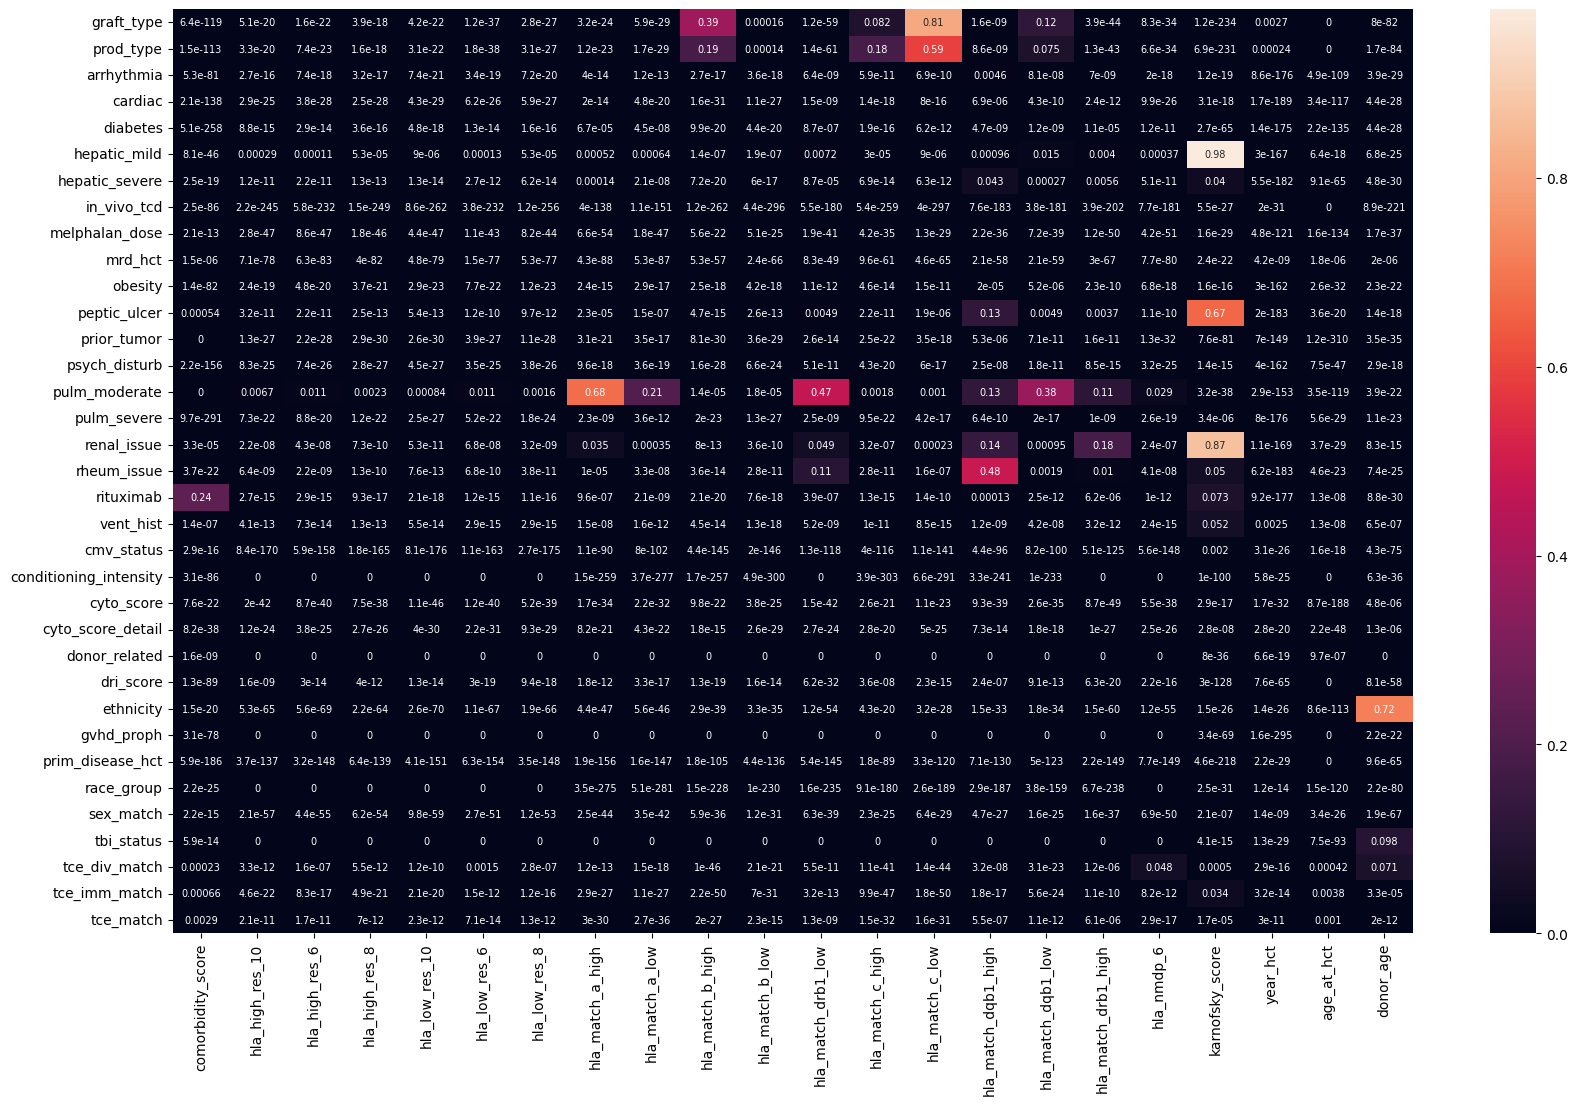

In [56]:
plt.figure(figsize = (20, 12))
df_krus_nc = sc.cache_result(
    'kruskal_num_cat',
    lambda : pd.concat([
        df_train.groupby(i, observed=True)[X_int + X_cont].agg(lambda x: list(x.dropna())).apply(
            lambda x: kruskal(*x).pvalue
        ).rename(i)
        for i in X_bool + X_tri + X_nom
    ], axis = 1), rerun = 0
)
sns.heatmap(
    df_krus_nc.T, annot=True, annot_kws = {'size': 7}
)
plt.show()

## Missing Variables

In [57]:
s_na_cnt = df_train.isna().mean().sort_values(ascending=False).pipe(lambda x: x.loc[x > 0])
X_na_val = s_na_cnt.index.tolist()
s_na_cnt.rename('na_cnt').to_frame()

,na_cnt
tce_match,0.659583
cyto_score_detail,0.413993
tce_div_match,0.395694
tce_imm_match,0.386562
cyto_score,0.280139
hla_high_res_10,0.248715
hla_high_res_8,0.202396
hla_high_res_6,0.183472
hla_match_dqb1_high,0.180521
hla_low_res_10,0.175833


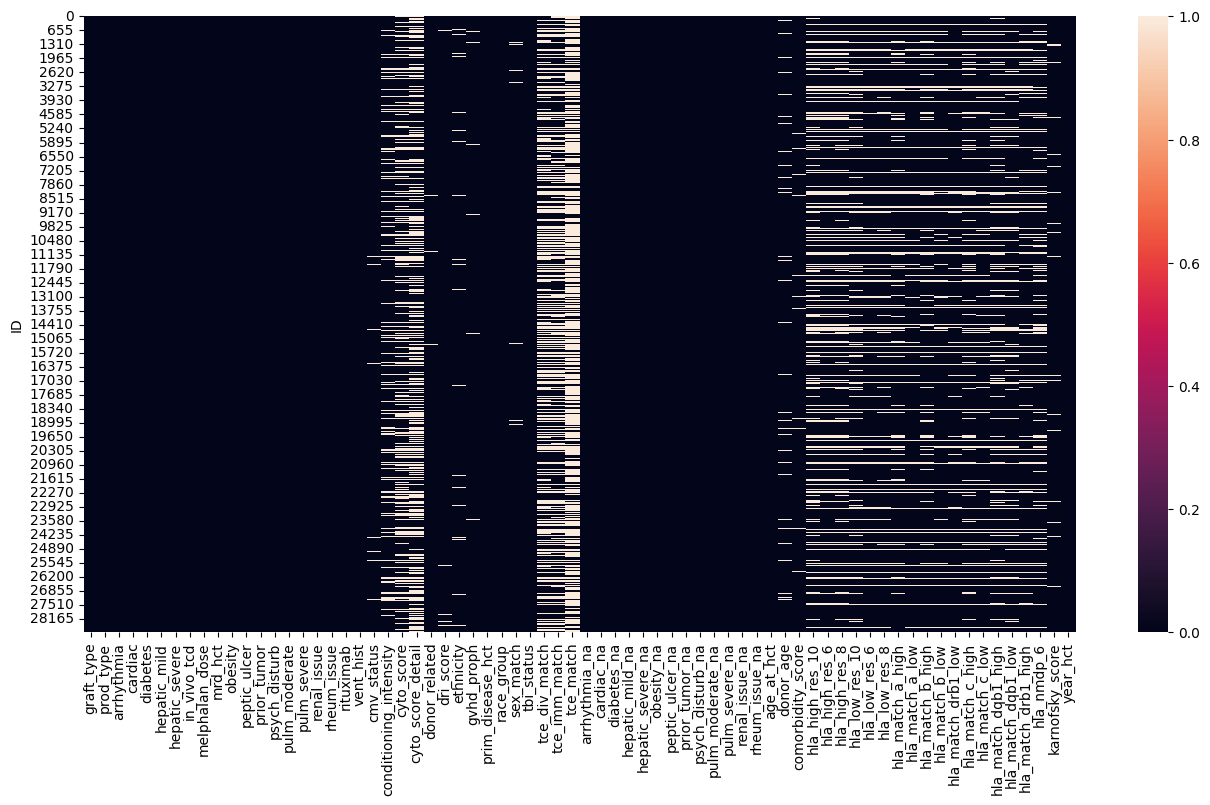

In [58]:
fig = plt.figure(figsize = (16, 8))
sns.heatmap(df_train[X_all].isna())
plt.show()

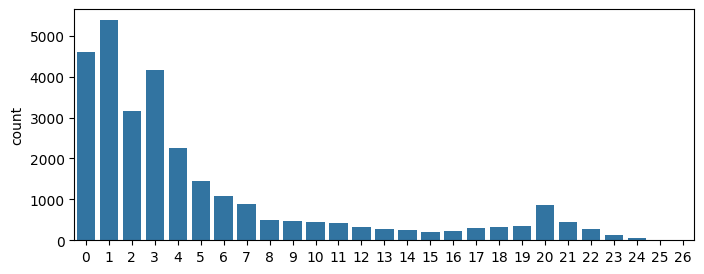

In [59]:
plt.figure(figsize = (8, 3))
sns.barplot(df_train[X_na_val].isna().sum(axis=1).value_counts())
plt.show()

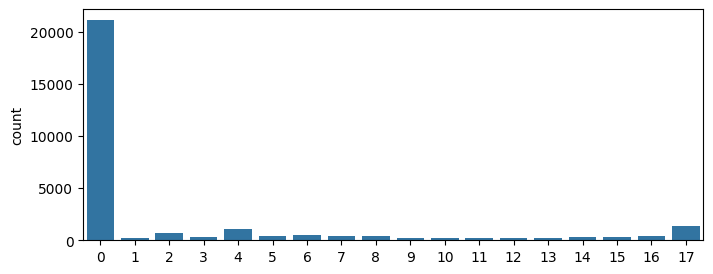

In [60]:
plt.figure(figsize = (8, 3))
sns.barplot(df_train[[i for i in X_all if i.startswith('hla_')]].isna().sum(axis=1).value_counts().pipe(lambda x: x.loc[x > 0]))
plt.show()

In [61]:
df_train.groupby('efs', observed = True).apply(
    lambda x: spearmanr(
        x['efs_time'], x[X_na_val].isna().sum(axis=1)
    ), include_groups = False
), spearmanr(df_train['efs_time'], df_train[X_na_val].isna().sum(axis=1))

(efs
 0.0    (0.018142147147810556, 0.036643764297283075)
 1.0      (0.01807121740359331, 0.02431138694979632)
 dtype: object,
 SignificanceResult(statistic=0.10851555129610958, pvalue=3.6369827549668586e-76))

In [62]:
df_train.groupby('efs', observed = True).apply(
    lambda x: spearmanr(
        x['efs_time'], x[[i for i in X_all if i.startswith('hla_')]].isna().sum(axis=1)
    ), include_groups = False
), spearmanr(df_train['efs_time'], df_train[[i for i in X_all if i.startswith('hla_')]].isna().sum(axis=1))

(efs
 0.0    (0.06972910762013518, 8.917784501708913e-16)
 1.0     (0.0664107957913549, 1.180211674761694e-16)
 dtype: object,
 SignificanceResult(statistic=0.02056704585114633, pvalue=0.00048200737442064565))

In [63]:
kruskal(*df_train.groupby('efs', observed = True)[X_na_val].apply(
        lambda x: x.isna().sum(axis=1).tolist()
    )
)

KruskalResult(statistic=389.617814764793, pvalue=1.0024888525359192e-86)

In [64]:
kruskal(*df_train.groupby('efs', observed = True)[[i for i in X_all if i.startswith('hla_')]].apply(
        lambda x: x.isna().sum(axis=1).tolist()
    )
)

KruskalResult(statistic=7.6664705616301925, pvalue=0.00562563910384482)

# 접근 방법

## Classification

성능 지표를 높히기 위해서는 efs, efs_time 두 개의 대상을 맞추도록 요구됩니다. 

efs 는 생존 여부를 나타내고, efs_time은 생존 시간을 나타내는데, 

efs가 1일 때는 efs_time은 생존한 시간을 나타내지만, 

efs가 0일 때는 efs_time은 생존해온 시간을 나타내기 때문에

efs 1일 때는, efs_time은 케이스에서 생존력을 나타내지만, efs 0일 때는 efs_time은 최소 생존력을 나타낸다는 점에서 의미에 차이가 납니다.

efs가 0일 때는 efs_time을 예상하는 것은 환자의 위험도를 완전히 예상할 수 있지만,

efs가 1일 대는 efs_time을 예상하는 것은 환자의 위험도 하기에는 부족함이 생깁니다. 

어떻게 대상 변수를 구성하여 지표를 만들어 갈 지 방향성을 알아 봅니다.

## 생존 시간을 기준으로 데이터 선별

efs 0일 때는 efs_time은 낮은 쪽에 집중적으로 분포하고 efs 1일 때는 efs_time은 넓게 분포합니다. efs_time이 클 수록 위험도가 낮은 환자임은 변수 특성상 자명합니다. 이러한 특성을 이용하여 위험한지 위험하지 않은지를 분류하는데 efs_time의 경계를 어디에 정했을 때 최적의 concordance index를 도출할 수 있을 지를 살펴봅니다.

In [122]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
skf = StratifiedKFold(5, random_state = 123, shuffle = True)
for train_idx, valid_idx in skf.split(df_train[X_all], df_train['efs']):
    df_cv_train, df_valid = df_train.iloc[train_idx], df_train.iloc[valid_idx]
    t1, t2 = (
        df_cv_train.loc[df_cv_train['efs'] == 0.0, 'efs_time'].quantile(0.025),
        df_cv_train.loc[df_cv_train['efs'] == 1.0, 'efs_time'].quantile(0.6)
    )
    df_cv_train = df_cv_train.assign(efs_b = np.nan)
    df_cv_train.loc[(df_cv_train['efs'] == 0.0) & (df_cv_train['efs_time'] > t1), 'efs_b'] = 0
    df_cv_train.loc[(df_cv_train['efs'] == 1.0) & (df_train['efs_time'] < t2), 'efs_b'] = 1
    df_train_b = df_cv_train.loc[df_cv_train['efs_b'].notna()]
    print(t1, t2, len(df_train_b), len(df_train) - len(df_train_b))
    clf_lgb = lgb.LGBMClassifier(verbose = -1, n_estimators = 500, learning_rate = 0.02, class_weight={0.0: 1.0, 1.0: 1.0})
    clf_lgb.fit(df_train_b[X_all], df_train_b['efs_b'], categorical_feature = X_nom)
    prd1 = clf_lgb.predict_proba(df_train_b[X_all])[:, 1]
    prd2 = clf_lgb.predict_proba(df_cv_train[X_all])[:, 1]
    prd3 = clf_lgb.predict_proba(df_valid[X_all])[:, 1]
    print(
        roc_auc_score(df_train_b['efs'], prd1),
        roc_auc_score(df_cv_train['efs'], prd2),
        roc_auc_score(df_valid['efs'], prd3),
        concordance_index(df_train_b['efs_time'], -pd.Series(prd1, index = df_train_b.index), df_train_b['efs']),
        concordance_index(df_cv_train['efs_time'], -pd.Series(prd2, index = df_cv_train.index), df_cv_train['efs']),
        concordance_index(df_valid['efs_time'], -pd.Series(prd3, index = df_valid.index), df_valid['efs'])
    )

12.948999857902527 6.35099983215332 17803 10997
0.8783769230509977 0.8123610598940185 0.7307160315426156 0.7946273751612923 0.7480881345352604 0.6800056538938621
13.040975046157836 6.34499979019165 17800 11000
0.880247136628682 0.8142156645540204 0.7207348637515643 0.7970014301040814 0.750204428408631 0.6728232947883559
12.948999857902527 6.364999771118164 17802 10998
0.8784599920616063 0.8129079644239328 0.7320307924327614 0.7951438811991041 0.7482660917581373 0.6794697314339877
13.041050052642822 6.3429999351501465 17802 10998
0.8792699655237628 0.8156418567931376 0.714378279121437 0.7949434350307667 0.7484648265940168 0.6755002598243639
12.884050130844116 6.330999851226807 17802 10998
0.8778213798774313 0.8112163664985675 0.7260711710761942 0.7940211133582182 0.746926939314261 0.6781133199406464


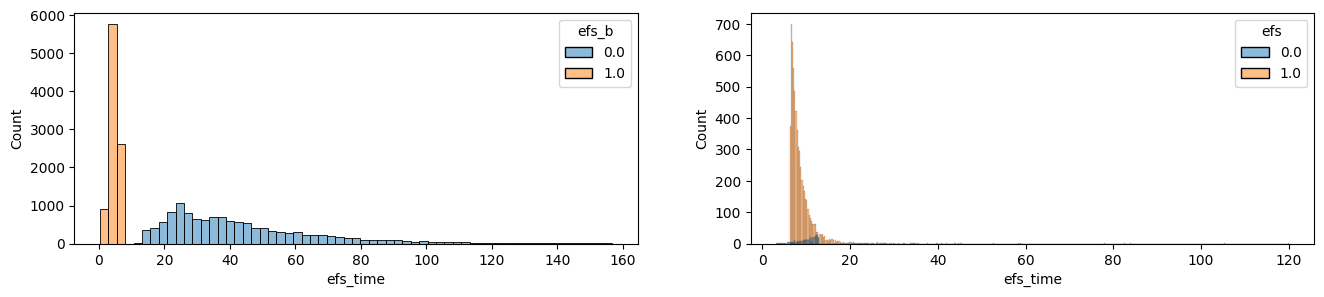

In [114]:
fig, axes = plt.subplots(1, 2, figsize = (16, 3))
t1, t2 = (
    df_train.loc[df_train['efs'] == 0.0, 'efs_time'].quantile(0.025),
    df_train.loc[df_train['efs'] == 1.0, 'efs_time'].quantile(0.6)
)
df_train['efs_b'] = np.nan
df_train.loc[(df_train['efs'] == 0.0) & (df_train['efs_time'] > t1), 'efs_b'] = 0
df_train.loc[(df_train['efs'] == 1.0) & (df_train['efs_time'] < t2), 'efs_b'] = 1
df_train_b = df_train.loc[df_train['efs_b'].notna()]
df_train_nb = df_train.loc[df_train['efs_b'].isna()]
sns.histplot(df_train_b, x = 'efs_time', hue='efs_b', ax = axes[0])
sns.histplot(df_train_nb, x = 'efs_time', hue='efs', ax = axes[1])
plt.show()

## Regression

### KaplanMeierFitter

[GPU LightGBM Baseline - [CV 681 LB 685]](https://www.kaggle.com/code/cdeotte/gpu-lightgbm-baseline-cv-681-lb-685) 에서 efs와 efs_time를 

하나의 회귀 변수로 변환하여, 예측 모델을 방법을 제시했습니다. 회귀 변수로 변환하는 부분을 가져와 봅니다.


In [65]:
from lifelines import KaplanMeierFitter
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y
df_train['kmf'] = transform_survival_probability(df_train, time_col='efs_time', event_col='efs')

In [70]:
from sklearn.model_selection import KFold
cross_validate(
    lgb.LGBMRegressor(verbose = -1, num_leaves = 64, n_estimators = 300), df_train[X_all], df_train['kmf'], 
    cv = KFold(5, random_state = 123, shuffle = True), scoring = 'r2', params = {'categorical_feature': X_nom},
    return_train_score = True
)

{'fit_time': array([0.55344033, 0.98645186, 0.4897387 , 0.46805763, 0.49058318]),
 'score_time': array([0.0248847 , 0.03041482, 0.02525902, 0.02553678, 0.02531028]),
 'test_score': array([0.20231424, 0.18980566, 0.20536055, 0.21525943, 0.19379983]),
 'train_score': array([0.72627743, 0.72249718, 0.72407192, 0.71848113, 0.72404011])}

In [71]:
reg_lgb = lgb.LGBMRegressor(verbose = -1, num_leaves = 15, n_estimators = 40)
reg_lgb.fit(df_train[X_all], df_train['kmf'])
kmf_prd = reg_lgb.predict(df_train[X_all])

In [72]:
from sklearn.metrics import r2_score
(
    r2_score(df_train['kmf'], kmf_prd),
    concordance_index(df_train['efs_time'], -kmf_prd, df_train['efs'])
)

(0.2058645292882788, 0.68308679379018)

In [75]:
event_label = 'efs'
interval_label = 'efs_time'
prediction_label = 'prediction'
# Merging solution and submission dfs on ID
pd.concat([
    df_train[[event_label, interval_label, 'race_group']], -df_train['efs_time'].fillna(0).rename(prediction_label)
], axis=).groupby('race_group', observed=True).apply(
    lambda x: concordance_index(
            x[interval_label], -x[prediction_label], x[event_label]
    ), include_groups=False
).pipe(
    lambda x: float(x.mean() - x.std(ddof=0))
)

0.9999992915438323